# Constants Matter

## **Jed Brown**


## Ansys meeting

In [1]:
from IPython.display import SVG, Video, HTML, IFrame
import pandas as pd
import altair as alt
from io import StringIO
import numpy as np


# Nonlinear solid mechanics

<video src="figures/ratel/schwarz-q2-5x5x5-t20-l2-r2.ogv" width="50%" controls />

# The mathematician's way: $hp$ adaptive finite elements

Elliptic PDE always have singularities at reentrant corners (and Dirichlet to Neumann boundary transitions).

<img src="https://www.dealii.org/images/steps/developer/step-27-solution.png" width="80%" />

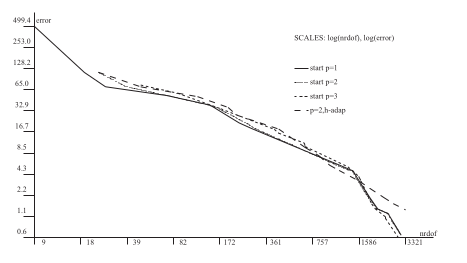
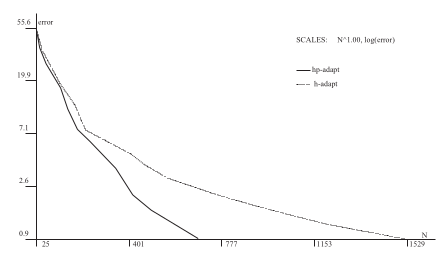

# How does it work?

High order to resolve when solution is smooth, tiny low-order elements near singularities.

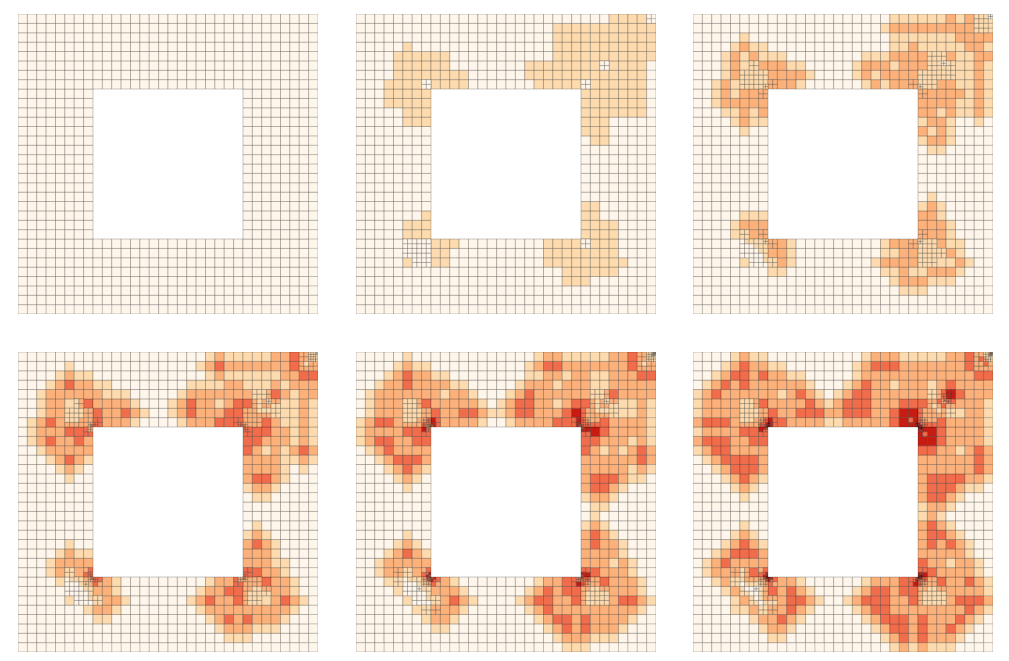

([source: Deal.II step 27](https://dealii.org/developer/doxygen/deal.II/step_27.html))

# What meshes do engineers use?

<img src="https://images.ansys.com/is/image/ansys/fundamentals-of-fea-meshing-cages-motorcycle-pump?&wid=866&op_usm=0.9,1.0,20,0&fit=constrain,0" width="100%" />

[source: Ansys blog](https://www.ansys.com/blog/fundamentals-of-fea-meshing-for-structural-analysis)

<video src="figures/ratel/one-hole-traction-20220222.ogv" controls />

# Approximation constants are good for high order

Assembly/solve cost goes up for high order using sparse matrices.

<img src="figures/ratel/p-refinement-2.svg" width="80%" />

# Why matrix-free?

* Assembled matrices need at least 4 bytes transferred per flop. Hardware does 10 flops per byte.
* Matrix-free methods store and move less data, compute faster.

<img src="figures/karlrupp/flop-per-byte-dp-2021.svg" class="floatleft" />
<img src="figures/TensorVsAssembly-qstore.svg" class="floatright" />

# Cost per Degree of Freedom (DoF) is good for high order

In [23]:
IFrame("figures/ratel/schwarz-q2-flame.svg", width="1900", height="300")

In [25]:
df = pd.DataFrame([ # data from ceed/ceed/papers/ecp-special-gpu/figures/libceed/ceedpavsfa.tex
["CuSparse", 1, 1755570000],
["CuSparse", 2, 1230490000],
["CuSparse", 3, 720458000],
["CuSparse", 4, 248439000],
["CuSparse", 5, 172816000],
["CuSparse", 6, 103112000],
["CuSparse", 7, 83081600],
["CuSparse", 8, 40645000],
["libCEED", 1, 1572540000],
["libCEED", 2, 3616390000],
["libCEED", 3, 3937560000],
["libCEED", 4, 4134010000],
["libCEED", 5, 4062560000],
["libCEED", 6, 4148760000],
["libCEED", 7, 3579790000],
["libCEED", 8, 3839100000],
], columns=["code", "polynomial degree", "DoF/s"])
df['GDoF/s'] = 1e-9 * df['DoF/s']
base = alt.Chart(df).encode(
    alt.X("polynomial degree:O"),
    alt.Y("GDoF/s"),
)
alt.layer(
    base.mark_point().encode(shape="code", color="code"),
    base.mark_line().encode(alt.Color("code", legend=None)),
).resolve_scale(
    color="independent",
    shape="independent",
).properties(width=600)

alt.LayerChart(...)

# Solve efficiency

<img src="figures/ratel/schwarz-q2-t20-r2-l2-KSPSolve.svg" />

<img src="figures/ratel/schwarz-q3-t20-r2-l1-SNESSolve.svg" />

## [libCEED](https://libceed.readthedocs.io): fast algebra for finite elements

* Backend plugins with run-time selection
  * debug/memcheck, optimized
  * libxsmm, CUDA, HIP
  * MAGMA to CUDA and HIP
  * OCCA to OpenMP, OpenCL, CUDA, and HIP
* Single source vanilla C for QFunctions
  * Easy to debug, understand locally, C++ optional
  * Target for DSLs, AD
* Python, Julia, Rust
* 2-clause BSD
* Available via MFEM, PETSc, Nek5000

<img src="figures/ceed/libceed-backends-tex.png" />

Thanks to many developers, including Jeremy Thompson, Yohann Dudouit, Valeria Barra, Natalie Beams,  Ahmad Abdelfattah, Leila Ghaffari, Will Pazner, Thilina Ratnayaka, Tzanio Kolev, Veselin Dobrev, David Medina

<img src="figures/ceed/libCEED-2.png" width=100% />


## Quadrature functions: the math

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    u = B_I \mathcal E_e u_L \qquad \nabla u = \frac{\partial X}{\partial x} B_{\nabla} \mathcal E_e u_L \\
    J w = \sum_e \mathcal E_e^T \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix}}_{\text{coefficients at quadrature points}} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix} \mathcal E_e w_L
\end{gather*}
  
* $B_I$ and $B_\nabla$ are tensor contractions -- independent of element geometry
* Choice of how to order and represent gathers $\mathcal E$ and scatters $\mathcal E^T$
* Similar for Neumann/Robin and nonlinear boundary conditions

## Quadrature functions: debuggable, vectorizable, and JITable

* Independent operations at each of `Q` quadrature points, order unspecified

```c
int L2residual(void *ctx, CeedInt Q,
    const CeedScalar *const in[],
    CeedScalar *const out[]) {
  const CeedScalar *u = in[0], *rho = in[1], *target = in[2];
  CeedScalar *v = out[0];
  for (CeedInt i=0; i<Q; i++)
    v[i] = rho[i] * (u[i] - target[i]);
  return 0;
}
```

![](figures/ceed/solids-perf-disassembly.png)

# BP performance on CPU (2x EPYC 7452)

In [5]:
from postprocess_base import read_logs
import altair as alt
from glob import glob

runs = read_logs(glob('data/ceed/**/*.txt'))
runs['FE_nodes_per_compute_node'] = runs['num_unknowns'] / (runs['num_procs'] / runs['num_procs_node']) / runs['dof_per_node']
runs.head()

,file,backend,backend_memtype,hostname,test,num_procs,num_procs_node,degree,quadrature_pts,code,bp,case,num_unknowns,num_elem,dof_per_node,ksp_its,time_per_it,cg_iteration_dps,FE_nodes_per_compute_node
0,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 1,1,1,1,3,libCEED,1,scalar,5616,4692,1,5,0.000362,15509500.0,5616.0
1,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 2,1,1,1,3,libCEED,2,vector,16848,4692,3,5,0.000366,46092000.0,5616.0
2,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 3,1,1,1,3,libCEED,3,scalar,3872,4692,1,1,0.000499,7762750.0,3872.0
3,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 4,1,1,1,3,libCEED,4,vector,11616,4692,3,1,0.000517,22485700.0,3872.0
4,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 1,1,1,1,3,libCEED,1,scalar,10800,9384,1,5,0.000363,29759700.0,10800.0


In [6]:
highlight = alt.selection_single(
    on='mouseover',
    fields=['degree', 'time_per_it', 'backend', 'hostname'],
    nearest=True,
    empty='none',
)

bps_select = alt.selection_single(
    fields=['bp'],
)

base = alt.Chart(runs[runs.hostname == "noether"]).encode(
    alt.Y('mdofs:Q', title='MDoF/s per CG iteration'),
    alt.Color('degree:N'),
    alt.Size('num_unknowns', scale=alt.Scale(type='log', domain=(1e3, 1e6))),
    alt.Shape('bp:N'),
    tooltip=('hostname', 'bp', 'num_procs', 'backend', 'num_elem', 'degree', 'num_unknowns', 'file'),
).transform_filter(
    bps_select,
).transform_calculate(
    mdofs='datum.cg_iteration_dps/1e6',
)

points = base.mark_point().encode(
    opacity=alt.condition(highlight, alt.value(1), alt.value(.5)),
).add_selection(
    highlight,
)

lines = base.mark_line().encode(
    size=alt.condition(alt.datum.degree - highlight.degree == 0, alt.value(2), alt.value(1))
)

pane = points + lines

composite = (
    pane.encode(
        alt.X('time_per_it', scale=alt.Scale(type='log'), title='Time per Iteration'),
    ).properties(width=600, height=600) |
    pane.encode(
        alt.X('FE_nodes_per_compute_node', scale=alt.Scale(type='log', domain=(3e4, 1e7), clamp=True), title='FE Nodes per Compute Node'),
    ).properties(width=600, height=600)
)

activator = alt.Chart(runs).mark_point().encode(
    alt.Y('bp', title='BP'),
    alt.Shape('bp')
).add_selection(bps_select).properties(title='Selection')

activator | composite.properties(title='CEED BPs')

alt.HConcatChart(...)

# BP performance on GPU (V100)

In [7]:
base = alt.Chart(runs[runs.hostname == "lassen385"]).encode(
    alt.Y('mdofs:Q', title='MDoF/s per CG iteration'),
    alt.Color('degree:N'),
    alt.Size('num_unknowns', scale=alt.Scale(type='log', domain=(1e3, 1e6))),
    alt.Shape('bp:N'),
    tooltip=('hostname', 'bp', 'num_procs', 'backend', 'num_elem', 'degree', 'num_unknowns', 'file'),
).transform_filter(
    bps_select,
).transform_calculate(
    mdofs='datum.cg_iteration_dps/1e6',
)

points = base.mark_point().encode(
    opacity=alt.condition(highlight, alt.value(1), alt.value(.5)),
).add_selection(
    highlight,
)

lines = base.mark_line().encode(
    size=alt.condition(alt.datum.degree - highlight.degree == 0, alt.value(2), alt.value(1))
)

pane = points + lines

composite = (
    pane.encode(
        alt.X('time_per_it', scale=alt.Scale(type='log'), title='Time per Iteration'),
    ).properties(width=600, height=600) |
    pane.encode(
        alt.X('FE_nodes_per_compute_node', scale=alt.Scale(type='log', domain=(3e4, 1e7), clamp=True), title='FE Nodes per Compute Node'),
    ).properties(width=600, height=600)
)

activator = alt.Chart(runs).mark_point().encode(
    alt.Y('bp', title='BP'),
    alt.Shape('bp')
).add_selection(bps_select).properties(title='Selection')

activator | composite.properties(title='CEED BPs')

alt.HConcatChart(...)

# libCEED and PETSc asynchrony

![](figures/ceed/libceed-bp3-nsys-cuda-gen.png)

# [Hyperelastic solids](https://libceed.readthedocs.io/en/latest/examples/solids/)

* $p$-multigrid, low-memory repr of matrix-free Jacobian
* Multi-node GPU on CUDA and ROCm

<img src="figures/ceed/libceed-solids-twist.gif" class="floatleft" />
<img src="figures/micromorph/libceed-epoxy-traction-20210829.gif" class="floatright" />

# libCEED solid mechanics flame graphs

In [4]:
IFrame("data/ceed/noether/noether-solids-holes-P4-xsmm-coo.svg", width="1600", height="900")

# Solids: efficient matrix-free Jacobians, cf. [Davydov et al. (2020)](https://doi.org/10.1002/nme.6336)

<img src="figures/ceed/libceed-solids-initial-current.png" width="80%" />
<img src="figures/ceed/libceed-solids-jacobian-table.png" width="80%" />